# Importa dependências

In [381]:
import pdfplumber as pdfpb
import json
import os
import re
import os.path as osp
import pathlib
import tarfile
import bz2
from zipfile import ZipFile
from pyunpack import Archive


##Classe com vários métodos de pre-processamento de texto em português criado pelo grupo F03
import utils.preprocessing_portuguese as preprossPT

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from matplotlib import pyplot as plt, rcParams, ticker
import seaborn as sns
import numpy as np
import pandas as pd 

# Cálculo do TF-IDF

In [2]:
def limpeza_texto(page_text):
    txt_process = preprossPT.TextPreProcessing()
    
    page_text = page_text.lower()
    
    page_text = txt_process.remove_pronouns(page_text)

    page_text = txt_process.remove_reduced_or_contracted_words(page_text)

    page_text = txt_process.remove_adverbs(page_text)

    page_text = txt_process.remove_special_characters(page_text)

    page_text = txt_process.remove_excessive_spaces(page_text)

    page_text = txt_process.remove_accents(page_text)

    page_text = txt_process.remove_stopwords(page_text)

    page_text = txt_process.remove_symbols_from_numbers(page_text)

    page_text = txt_process.remove_numbers(page_text)

    page_text = txt_process.remove_urls(page_text)
    
    page_text = txt_process.remove_person_names(page_text)
    
    #Removendo letras sozinhas no texto
    page_text = re.sub(r'(?:^| )\w(?:$| )', ' ', page_text).strip()

    page_text = page_text.replace("_","")
    
    return page_text

In [4]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [5]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [5]:
base_path = "../data/documentos_municipios/docs-cidades-jul2021/"

#filename = f"{base_path}documentos_json/pirapetinga.json"

files = os.listdir(base_path+"documentos_json/")



cities = [city.split(".")[0] for city in files if city.split(".")[1]=='json']

all_pages = []
##Ler até 10 páginas de cada arquivo
for page in range(10):

    pages_content = []

    #print(files)
    for filename in files:
        if os.path.splitext(filename)[1] == '.json':
            print("Municipio: ", filename)
            with open(base_path+"documentos_json/"+filename) as f:
                lines = f.readlines() # lê o conteúdo (pode ser lido em um stream, se achar necessário)
                #print("document id                     ", "  #", " status")
                for line in lines: # um doc por linha
                    document = json.loads(line) # alguns arquivos tem problemas, portanto, verifique o status.
                    #print(document["file_id"], f"{document['n_pages']:>03d}", document["status"])
                    if document["status"] != "FAILED" and document["text_content"]:
                        #print(document["file_id"])
                        #print(document["text_content"][0:1])
                        content = ""
                        #Pegar o conteúdo das páginas, incrementa a cada iteração
                        for k in range(page+1):
                            if len(document["text_content"]) > k:
                                content = content+" "+document["text_content"][k]
                        pages_content.append(content) 


    print(len(pages_content))
    for i in range(len(pages_content)):
        for city in cities:
            pages_content[i] = pages_content[i].lower().replace(city, "")
            
        pages_content[i] = limpeza_texto(pages_content[i])

    #print(pages_content[0])
    all_pages.append(pages_content)

Municipio:  pirapetinga.json
Municipio:  cristais.json
Municipio:  coqueiral.json
Municipio:  olaria.json
Municipio:  arantina.json
Municipio:  passa-vinte.json
Municipio:  ijaci.json
Municipio:  sao-bento-abade.json
Municipio:  itamarati2017.json
Municipio:  itamarati2018.json
Municipio:  itamarati2019.json
Municipio:  itamarati2020.json
Municipio:  ribeirao-vermelho.json
5876
Municipio:  pirapetinga.json
Municipio:  cristais.json
Municipio:  coqueiral.json
Municipio:  olaria.json
Municipio:  arantina.json
Municipio:  passa-vinte.json
Municipio:  ijaci.json
Municipio:  sao-bento-abade.json
Municipio:  itamarati2017.json
Municipio:  itamarati2018.json
Municipio:  itamarati2019.json
Municipio:  itamarati2020.json
Municipio:  ribeirao-vermelho.json
5876
Municipio:  pirapetinga.json
Municipio:  cristais.json
Municipio:  coqueiral.json
Municipio:  olaria.json
Municipio:  arantina.json
Municipio:  passa-vinte.json
Municipio:  ijaci.json
Municipio:  sao-bento-abade.json
Municipio:  itamarati

KeyboardInterrupt: 

## Recupera o texto de todos os documentos

In [6]:
base_path = "../data/documentos_municipios/docs-cidades-jul2021/"

#filename = f"{base_path}documentos_json/pirapetinga.json"

files = os.listdir(base_path+"documentos_json/")



cities = [city.split(".")[0] for city in files if city.split(".")[1]=='json']

pages_content = []
#print(files)
for filename in files:
    if os.path.splitext(filename)[1] == '.json':
        print("Municipio: ", filename)
        with open(base_path+"documentos_json/"+filename) as f:
            lines = f.readlines() # lê o conteúdo (pode ser lido em um stream, se achar necessário)
            #print("document id                     ", "  #", " status")
            for line in lines: # um doc por linha
                document = json.loads(line) # alguns arquivos tem problemas, portanto, verifique o status.
                #print(document["file_id"], f"{document['n_pages']:>03d}", document["status"])
                if document["status"] != "FAILED" and document["text_content"]:
                    #print(document["file_id"])
                    #print(document["text_content"][0:1])
                    #Pegar o conteúdo das páginas, incrementa a cada iteração                    
                    pages_content.append(document["text_content"]) 

Municipio:  pirapetinga.json
Municipio:  cristais.json
Municipio:  coqueiral.json
Municipio:  olaria.json
Municipio:  arantina.json
Municipio:  passa-vinte.json
Municipio:  ijaci.json
Municipio:  sao-bento-abade.json
Municipio:  itamarati2017.json
Municipio:  itamarati2018.json
Municipio:  itamarati2019.json
Municipio:  itamarati2020.json
Municipio:  ribeirao-vermelho.json


In [10]:
unprocessed_texts = pages_content

In [12]:
from tqdm import tqdm_notebook

In [ ]:
print(len(unprocessed_texts))
for i in tqdm_notebook(range(len(unprocessed_texts))):
    for city in cities:
        pages_content[i] = [page.lower().replace(city, "") for page in unprocessed_texts[i]]

    pages_content[i] = [limpeza_texto(page) for page in pages_content[i]]

5876


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [65]:

results = {}
frequency = []
feature_names = []

for num_pages in range(10):
    vectorizer = CountVectorizer()
    # calcula tf
    corpus = [' '.join(page[:num_pages+1]) for page in pages_content]
    frequency = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()

    tfidf_transformer = TfidfTransformer()
    inv_doc_freq = tfidf_transformer.fit(frequency)

    df = pd.DataFrame(columns = feature_names)
    df.loc[len(df)] = np.squeeze(np.asarray(frequency.sum(axis=0)))
    df.loc[len(df)] = inv_doc_freq.idf_
    results[num_pages+1] = df

    # top k  frequency
    #df.T.sort_values(by=0, ascending=False).head(10).T

    # top k idf
    #df.T.sort_values(by=1, ascending=False).head(10).T

In [67]:
# All pages
num_pages = 1000
vectorizer = CountVectorizer()
# calcula tf
corpus = [' '.join(page[:num_pages+1]) for page in pages_content]
frequency = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()

tfidf_transformer = TfidfTransformer()
inv_doc_freq = tfidf_transformer.fit(frequency)

df = pd.DataFrame(columns = feature_names)
df.loc[len(df)] = np.squeeze(np.asarray(frequency.sum(axis=0)))
df.loc[len(df)] = inv_doc_freq.idf_
results[num_pages+1] = df

# Tamanho do vocabulario

<BarContainer object of 11 artists>

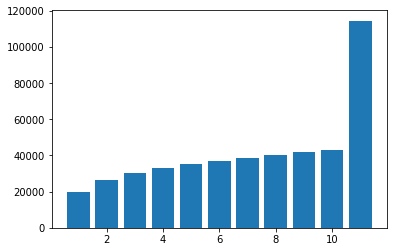

In [74]:
vocab_size = []
for key in results.keys():
    vocab_size.append(results[key].shape[1])
plt.bar(range(1,12),vocab_size)

In [168]:
for key in results.keys():
    if key == 1001:
        prefix = "{}_page".format("All")
    else:
        prefix = "{}_page".format(key)        
    
    df = results[key].astype(float)
    df_tf = df.T.sort_values(by=0,ascending=False).reset_index().reset_index().drop(1, axis=1)
    df_tf.columns = ["{}_index".format(prefix),"{}_term".format(prefix), "{}_tf".format(prefix)]
    
    df_idf = df.T.sort_values(by=1,ascending=False).reset_index().reset_index().drop(0, axis=1)
    df_idf.columns = ["{}_index".format(prefix),"{}_term".format(prefix), "{}_idf".format(prefix)]
    if key == 1:
        df_tf_all = df_tf.copy()
        df_idf_all = df_idf.copy()
    else:
        df_tf_all = pd.concat([df_tf_all, df_tf], axis=1)
        df_idf_all = pd.concat([df_idf_all, df_idf], axis=1)

In [326]:
from matplotlib import rcParams
import matplotlib.cm as cm

# figure size in inches
rcParams['figure.figsize'] = 20,10

In [ ]:
def insert_terms_in_graph(df, terms, tf, pages_to_plot):
    scatters = []
    #term_columns = [col for col in df.columns if "term" in col]
    suffix = 'term'
    if pages_to_plot == "All":
        term_columns = [col for col in df.columns if suffix in col]
    else:
        list_of_pages = [str(i+1) for i in range(pages_to_plot)]
        term_columns = [col for col in df.columns if suffix in col and col.split("_")[0] in list_of_pages]
    colors = cm.rainbow(np.linspace(0, 1, len(terms)))
    #colors = ['b', 'g', 'r', 'c', 'k', 'm', 'y']
    for i, term in enumerate(terms):
        points = []
        for col in term_columns:
            num_pages = col.split("_")[0]
            try:
                if tf:
                    points.append(df.loc[df[col] == term, ["{}_page_index".format(num_pages), "{}_page_tf".format(num_pages)]].values[0])
                else:
                    points.append(df.loc[df[col] == term, ["{}_page_index".format(num_pages), "{}_page_idf".format(num_pages)]].values[0])
            except:
                print(term)
                break
        x_axis = [point[0] for point in points]
        y_axis = [point[1] for point in points]
        if i%2 == 0:
            marker = "x"
        else:
            marker = "o"
        scatters.append(plt.scatter(x=x_axis, y=y_axis,zorder=100, color=colors[i], label=term, marker=marker))
        #plt.yscale('log')
    
    """plt.legend(scatters,
                   terms,
                   scatterpoints=1,
                   loc='upper right',
                   ncol=3,
                   fontsize=8)"""

In [ ]:
terms =  ['convite','ata', 'edital', 'adjudicacao', 'homologacao', 'errata', 'anexo', 'aditivo', 'habilitacao', 'julgamento', 'designacao', 'aviso', 'contrato',  'deliberacao', 'revogacao']

In [1161]:
def plot_lines(df, terms, tf, terms_filter = None, pages_to_plot = "All", figsize=(10.4,7)):
    if tf:
        suffix = 'tf'
    else:
        suffix = 'idf'
    if pages_to_plot == "All":
        cols_to_plot = [col for col in df.columns if suffix in col]
    else:
        list_of_pages = [str(i+1) for i in range(pages_to_plot)]
        cols_to_plot = [col for col in df.columns if suffix in col and col.split("_")[0] in list_of_pages]
    plt.figure(figsize=figsize)
    for col in cols_to_plot:
        num_pages = col.split("_")[0]
        #points = df[["{}_page_index".format(num_pages), "{}_page_{}".format(num_pages, suffix)]].values#[10000:]
        if terms_filter != None:            
            points = df.loc[df["{}_page_term".format(num_pages)].isin(terms_filter[num_pages]), ["{}_page_index".format(num_pages), "{}_page_{}".format(num_pages, suffix)]].values#[10000:]
        else:
            points = df[["{}_page_index".format(num_pages), "{}_page_{}".format(num_pages, suffix)]].values#[10000:]
        if num_pages == str(1):
            plt.plot(points[:,0], points[:,1], label="{}_pag".format(num_pages), zorder = 80)
        elif num_pages == "All":
            plt.plot(points[:,0], points[:,1], label="Todas_pags", zorder = 80)
        else:
            plt.plot(points[:,0], points[:,1], label="1-{}_pags".format(num_pages), zorder = 80)

    insert_terms_in_graph(df, terms, tf, pages_to_plot)
    
    plt.grid(zorder=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(ncol=6,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
    if tf:
        #plt.yscale('log')
        #plt.legend( ncol=3, loc='upper right')
        plt.ylabel("Frequência dos Termos")
    else:
        #plt.legend(ncol=6,bbox_to_anchor=(0, -0.27), loc='lower left', borderaxespad=0.)
        plt.ylabel("Frequência Inversa dos Documentos")
    plt.xlabel("Rank")
    plt.tight_layout()
    plt.show()
    
def plot_vocab_size(vocab_dict, figsize=(10,6)):
    x_label = []
    y_axis = []
    for key in vocab_dict.keys():
        y_axis.append(len(vocab_dict[key]))
        x_label.append(key)
    plt.figure(figsize=figsize)
    splot = sns.barplot(x= x_label, y=y_axis, color='#66c3a6', zorder=100)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    plt.grid(zorder=1)
    plt.xlabel("Número de Páginas")
    plt.ylabel("Tamanho do Vocabulário")
    plt.show()

In [1355]:
def plot_lines(df, terms, tf, terms_filter = None, pages_to_plot = "All", figsize=(10.4,7)):
    if tf:
        suffix = 'tf'
    else:
        suffix = 'idf'
    if pages_to_plot == "All":
        cols_to_plot = [col for col in df.columns if suffix in col]
    else:
        list_of_pages = [str(i+1) for i in range(pages_to_plot)]
        cols_to_plot = [col for col in df.columns if suffix in col and col.split("_")[0] in list_of_pages]
    #plt.figure(figsize=figsize)
    fig, ax = plt.subplots(figsize=figsize)
    for col in cols_to_plot:
        num_pages = col.split("_")[0]
        #points = df[["{}_page_index".format(num_pages), "{}_page_{}".format(num_pages, suffix)]].values#[10000:]
        if terms_filter != None:            
            points = df.loc[df["{}_page_term".format(num_pages)].isin(terms_filter[num_pages]), ["{}_page_index".format(num_pages), "{}_page_{}".format(num_pages, suffix)]].values#[10000:]
        else:
            points = df[["{}_page_index".format(num_pages), "{}_page_{}".format(num_pages, suffix)]].values#[10000:]
        if num_pages == str(1):
            ax.plot(points[:,0], points[:,1], label="{}_pag".format(num_pages), zorder = 80)
        elif num_pages == "All":
            ax.plot(points[:,0], points[:,1], label="Todas_pags", zorder = 80)
            max_x = max(points[:,0])
        else:
            ax.plot(points[:,0], points[:,1], label="1-{}_pags".format(num_pages), zorder = 80)

    insert_terms_in_graph(df, terms, tf, pages_to_plot)
    
    ax.grid(zorder=1)
    plt.yscale('log')
    plt.xscale('log')

    if tf:
        #plt.yscale('log')
        #plt.legend( ncol=3, loc='upper right')
        plt.ylabel("Frequência dos Termos")
    else:
        #ax.set_yticklabels()
        #plt.legend(ncol=6,bbox_to_anchor=(0, -0.27), loc='lower left', borderaxespad=0.)
        if num_pages == "All":
            plt.plot( [0,max_x],[8,8], color='k', linestyle='dashed')
        plt.ylabel("Frequência Inversa dos Documentos")
        #plt.yticks([x for x in range(1,11)])        
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        #ax.set_yticklabels([str(x) for x in range(1,11)]) 
    plt.legend(ncol=6,bbox_to_anchor=(0, -0.35), loc='lower left', borderaxespad=0.)
    plt.xlabel("Rank (Tamanho do Vocabulário)")
    plt.tight_layout()
    plt.show()
    
def plot_vocab_size(vocab_dict, figsize=(10.4,7)):
    x_label = []
    y_axis = []
    for key in vocab_dict.keys():
        y_axis.append(len(vocab_dict[key][0]))
        x_label.append(key)
    plt.figure(figsize=figsize)
    splot = sns.barplot(x= x_label, y=y_axis, color='#66c3a6', zorder=100)
    
    x_label = []
    y_axis = []    
    for key in vocab_dict.keys():
        y_axis.append(len(vocab_dict[key][1]))
        x_label.append(key)
    #plt.figure(figsize=figsize)
    splot2 = sns.barplot(x= x_label, y=y_axis, color='#c3ac66',  zorder=101)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    for p in splot2.patches:
        splot2.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points', zorder=102)
    plt.legend(["Todos termos", "Termos com IDF < 8"])
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('#66c3a6')
    leg.legendHandles[1].set_color('#c3ac66')
    plt.grid(zorder=1)
    plt.xlabel("Número de Páginas")
    plt.ylabel("Tamanho do Vocabulário")
    plt.show()

# Todas as páginas

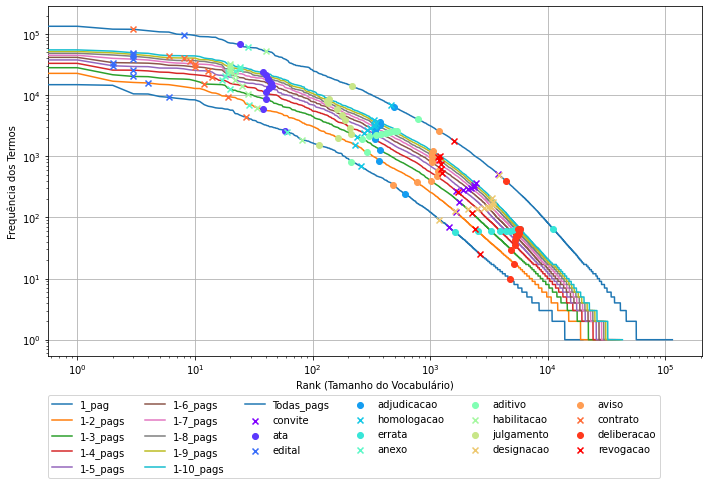

In [1356]:
plot_lines(df_tf_all, terms, tf = True, pages_to_plot="All", figsize=(10.4,7))

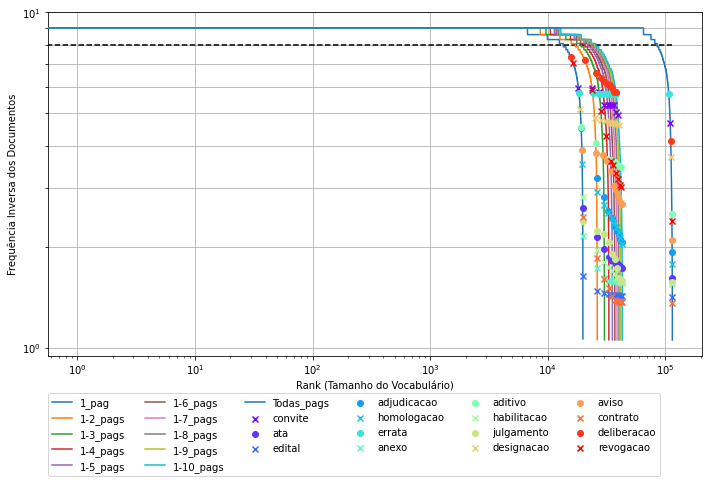

In [1357]:
plot_lines(df_idf_all, terms, tf = False, pages_to_plot="All", figsize=(10.4,7))

In [1359]:
# stacked
terms_filter = {}
for col in df_idf_all.columns:
    if "term" in col:
        key = col.split("_")[0]
        if key == "All":
            key_dict = "Todas_pags"
        else:
            key_dict = key
        terms_filter[key_dict] = [df_idf_all[col].dropna().values]
        terms_filter[key_dict].append(df_idf_all.loc[df_idf_all["{}_page_idf".format(key)] < 8, col].values)

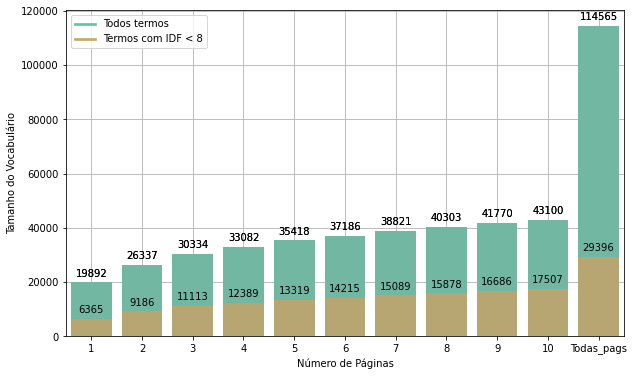

In [1360]:
plot_vocab_size(terms_filter, (10,6))

# Até 10 páginas

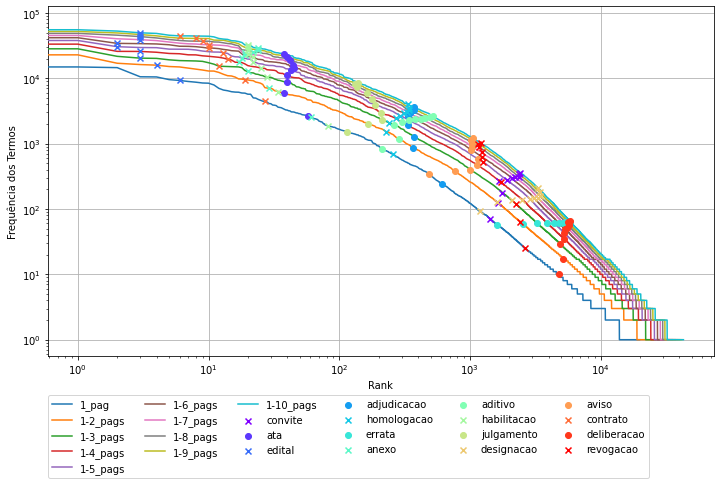

In [1167]:
pages_to_plot = 10
plot_lines(df_tf_all, terms, tf = True, pages_to_plot=pages_to_plot)

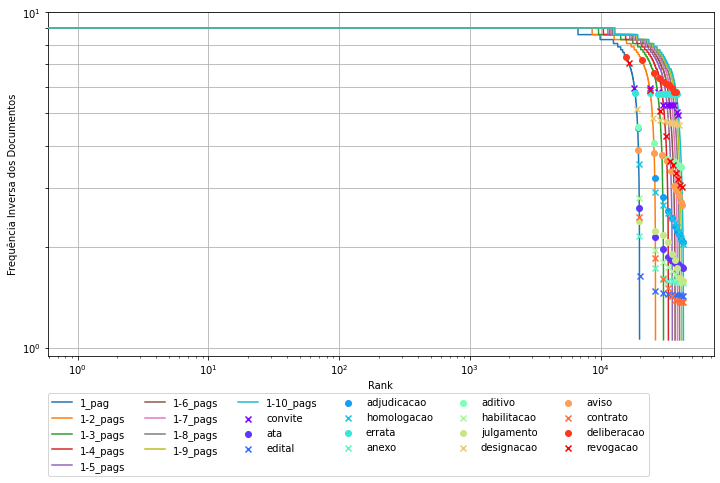

In [1168]:
plot_lines(df_idf_all, terms, tf = False, pages_to_plot=pages_to_plot,  figsize=(10.4,7))

# 10 primeiras páginas

## tf >= 5

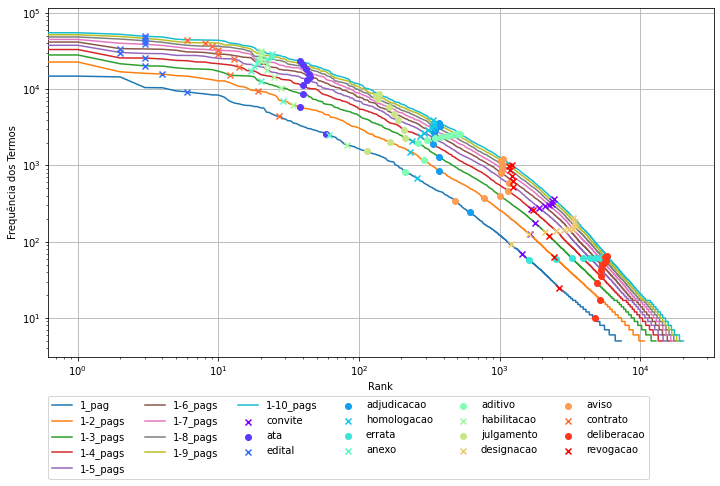

In [1169]:
suffix = 'tf'
terms_filter_tf = {}
num_pages = 10
filter_value_tf = 5
for num_page in range(1,num_pages+1):
    terms_filter_tf[str(num_page)] = df_tf_all.loc[df_tf_all["{}_page_tf".format(num_page)] >= filter_value_tf, ["{}_page_term".format(num_page)]].values[:,0]
plot_lines(df_tf_all, terms, True, terms_filter_tf, num_pages)

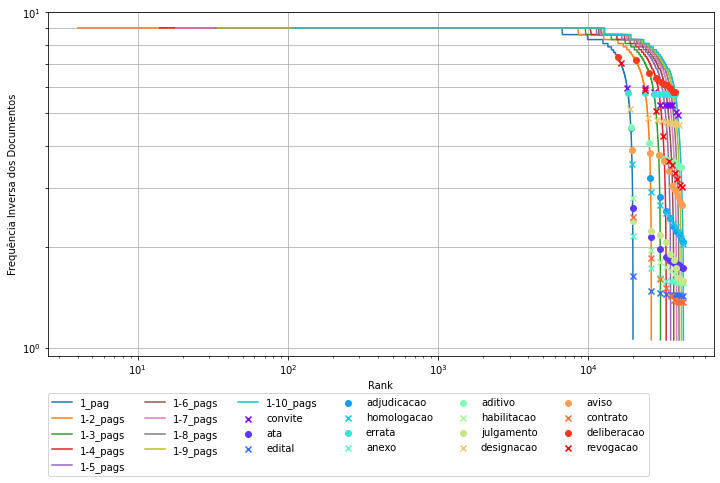

In [1170]:
plot_lines(df_idf_all, terms, False, terms_filter_tf, num_pages)

## idf < 8

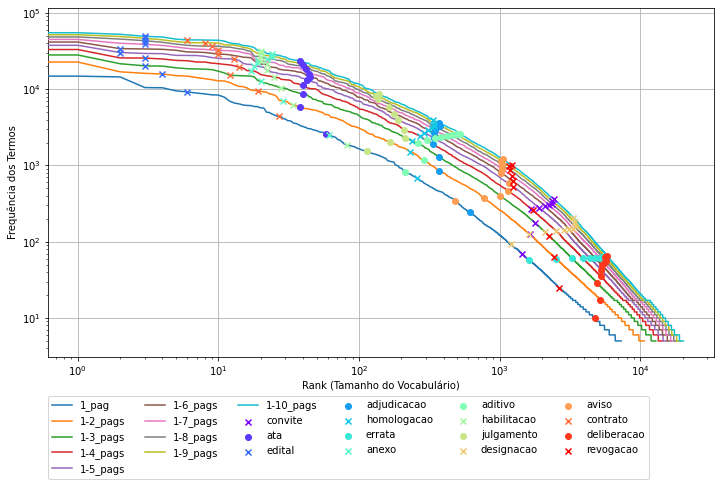

In [1361]:
suffix = 'idf'
terms_filter_idf = {}
num_pages = 10
filter_value_idf = 8
for num_page in range(1,num_pages+1):
    terms_filter_idf[str(num_page)] = df_idf_all.loc[df_idf_all["{}_page_idf".format(num_page)] < filter_value_idf, ["{}_page_term".format(num_page)]].values[:,0]    
plot_lines(df_tf_all, terms, True, terms_filter_idf, num_pages)

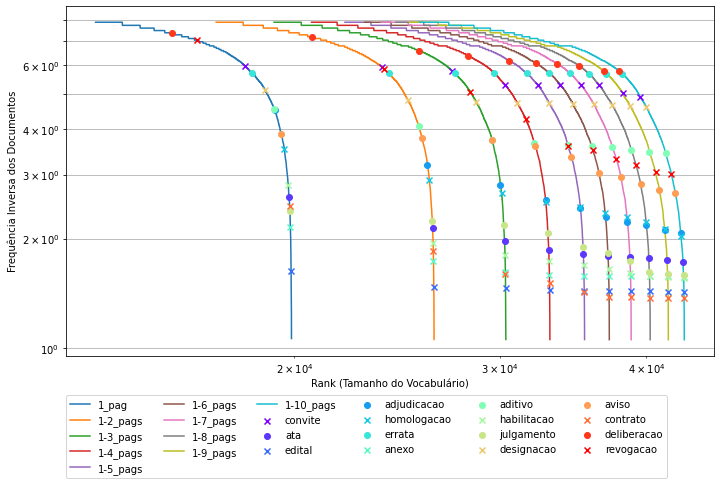

In [1362]:
plot_lines(df_idf_all, terms, False, terms_filter_idf, num_pages)#,  figsize=(10.55,7))

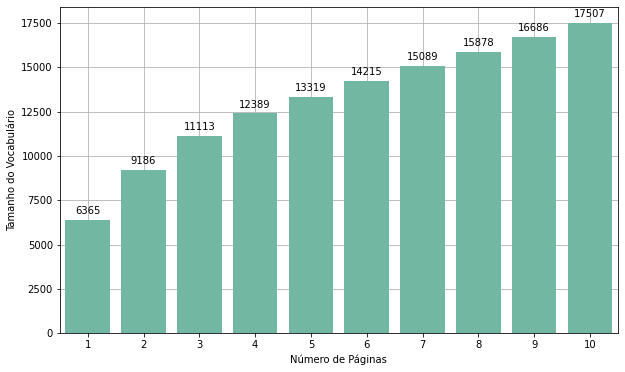

In [1173]:
plot_vocab_size(terms_filter_idf, (10,6))

## tf >=10 idf < 8

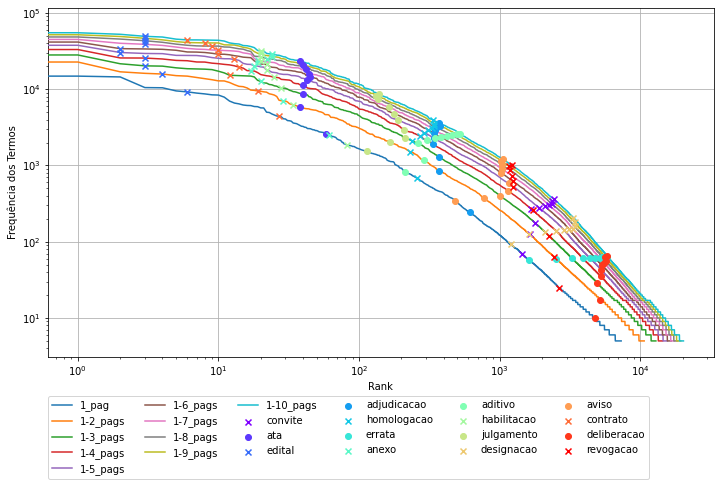

In [1174]:
suffix = 'idf'
terms_filter_intersection = {}
num_pages = 10
for num_page in range(1,num_pages+1): 
    terms_filter_intersection[str(num_page)] = set(terms_filter_idf[str(num_page)]).intersection(terms_filter_tf[str(num_page)])
plot_lines(df_tf_all, terms, True, terms_filter_intersection, num_pages)

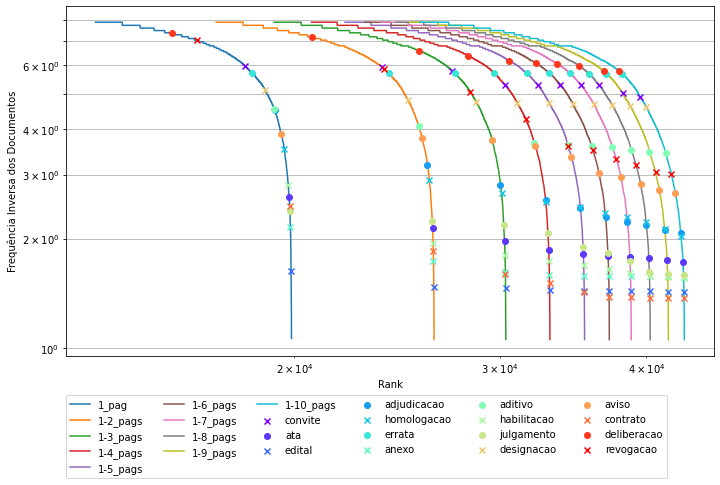

In [1175]:
plot_lines(df_idf_all, terms, False, terms_filter_intersection, num_pages)

In [1256]:
np.log(5876/20)+1

6.682899263739777

In [1250]:
df_idf_all.loc[df_idf_all['3_page_term'] == 'cid', '4_page_idf']

26447    6.845588
Name: 4_page_idf, dtype: float64

# Nuvem de palavras

In [1350]:
from wordcloud import WordCloud
def gera_wordcloud(df, pg, metodo, nomeArq, terms, figsize=(10.4,7)):
    
    # import the desired colormap from matplotlib
    cmap = mpl.cm.YlGnBu(np.linspace(0,1,20)) 
    # the darker part of the matrix is selected for readability
    cmap = mpl.colors.ListedColormap(cmap[-10:,:-1])
    
    #tf baixo tende a implicar em idf alto
    df = df.loc[df[pg+'_page_term'].isin(terms), [pg+'_page_term', pg+'_page_'+metodo]].sort_values(by=[pg+'_page_'+metodo], ascending=False)
    #print(df.head(30))

    df = df[(df[pg+"_page_term"] != "minas") & (df[pg+"_page_term"]  != "mg") & (df[pg+"_page_term"]  != "gerais")]
    #print(freq)
    dictTerm = dict(zip(df[pg+"_page_term"], df[pg+'_page_'+metodo]))
    
    #wordcloud = WordCloud(background_color="white", max_words=150, colormap=cmap).generate_from_frequencies(dictTerm)
    wordcloud = WordCloud(background_color="white", max_words=150, colormap=cmap, ).fit_words(dictTerm)
    plt.figure(figsize=figsize)
    
    # remove plot axes
    plt.axis("off")

    plt.imshow(wordcloud)

    # save the image
    #plt.savefig(base_path+nomeArq)

    
    

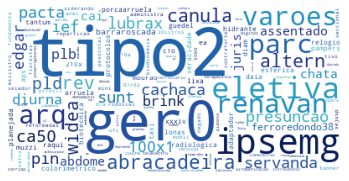

In [1298]:
#Filtrar IDF >= 8
idf = 8
terms_by_page_idf = []
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['1_page_idf'] >= idf, '1_page_term'].values)
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['2_page_idf'] >= idf, '2_page_term'].values)
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['3_page_idf'] >= idf, '3_page_term'].values)
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['4_page_idf'] >= idf, '4_page_term'].values)

gera_wordcloud(df_tf_all, str(1), "tf", "wordcloudIDFMa8_1pg.png", terms_by_page_idf[0], figsize=(6, 4))

gera_wordcloud(df_tf_all, str(2), "tf", "wordcloudIDFMa8_2pg.png", terms_by_page_idf[1], figsize=(6, 4))

gera_wordcloud(df_tf_all, str(3), "tf", "wordcloudIDFMa8_3pg.png", terms_by_page_idf[2], figsize=(6, 4))

gera_wordcloud(df_tf_all, str(4), "tf", "wordcloudIDFMa8_3pg.png", terms_by_page_idf[3], figsize=(6, 4))

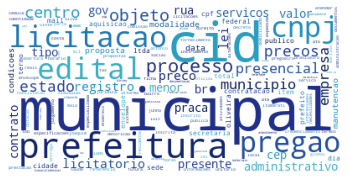

In [1351]:
#Filtrar IDF >= 8
idf = 8
terms_by_page_idf = []
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['1_page_idf'] < idf, '1_page_term'].values)
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['2_page_idf'] < idf, '2_page_term'].values)
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['3_page_idf'] < idf, '3_page_term'].values)
terms_by_page_idf.append(df_idf_all.loc[df_idf_all['4_page_idf'] < idf, '4_page_term'].values)

gera_wordcloud(df_tf_all, str(1), "tf", "wordcloudIDFMa8_1pg.png", terms_by_page_idf[0], figsize=(6, 4))

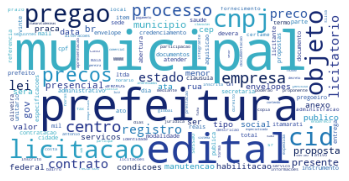

In [1352]:
gera_wordcloud(df_tf_all, str(2), "tf", "wordcloudIDFMa8_2pg.png", terms_by_page_idf[1], figsize=(6, 4))

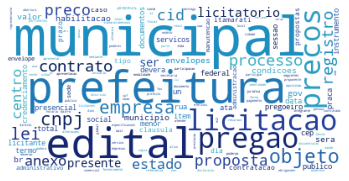

In [1353]:
gera_wordcloud(df_tf_all, str(3), "tf", "wordcloudIDFMa8_3pg.png", terms_by_page_idf[2], figsize=(6, 4))

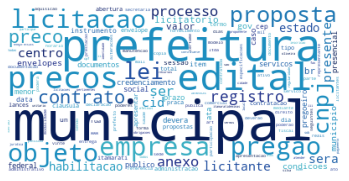

In [1354]:
gera_wordcloud(df_tf_all, str(4), "tf", "wordcloudIDFMa8_3pg.png", terms_by_page_idf[3], figsize=(6, 4))